**SSA Forecasting - Bao Ngoc Nguyen - UMass Amherst - Start: 3/20/2024 - End: undefined**

Import dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Loading dataset

In [2]:
with open("dataset.txt", "r") as file_solieu:
    data = np.loadtxt(file_solieu, dtype={'names': ('col1', 'col2'), 'formats': ('int', 'float')}, unpack=True)

**Step 1: Decomposition**

Separate values of column 2

In [3]:
Fi = data[1][1:]

Defining variables

In [4]:
N = 4900 # Number of signals to analyse
L = 100 # 2 < L < N - 1
K = N - L + 1
X = np.zeros((L, K)) # init X = (L, K)

In [5]:
for i in range(L): # Rows
    for j in range(K): # Columns
        X[i, j] = Fi[i + j]

Visualization of lagged vectors

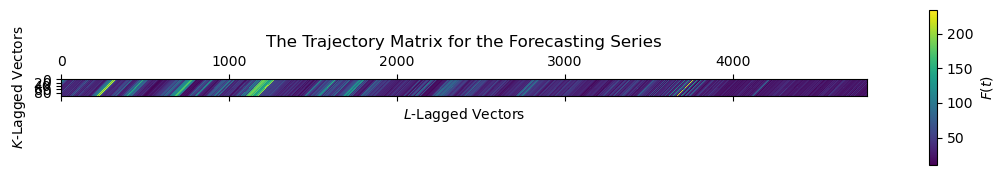

In [6]:
ax = plt.matshow(X)
plt.xlabel("$L$-Lagged Vectors")
plt.ylabel("$K$-Lagged Vectors")
plt.colorbar(ax.colorbar, fraction=0.3)
ax.colorbar.set_label("$F(t)$")
plt.title("The Trajectory Matrix for the Forecasting Series")
plt.show()

**Step 2: Singular value Decomposition**

In [ ]:
XT = np.transpose(X) # Tinh ma tran chuyen vi XT tu X su dung ham np.transpose
S = np.dot(X, XT) # Tinh nhan 2 ma tran X va XT ket qua gan cho bien S

In [ ]:
eigenvaluesS, eigenvectorsS = np.linalg.eig(S) # Tim gia tri rieng, vector rieng su dung ham np.linalg.eig
# eigenvaluesS se la gia tri rieng, eigenvectorsS se la vector rieng
# Gia tri rieng chua duoc sap xep

In [ ]:
ind = np.argsort(eigenvaluesS)[::-1] # Tim thu tu index duoc sap xep cua gia tri rieng
lambdaDecreasing = eigenvaluesS[ind] # Sap xep gia tri rieng
UiDecreasing = eigenvectorsS[:, ind] # Vector rieng cua tung gia tri rieng duoc sap xep tuong ung

In [ ]:
d = 0 # Khoi tao gia tri d
# Tinh d = max(i, sao cho lambda_i>0)
for i in range(L):
    if lambdaDecreasing[i] > 0: # neu gia tri lambdaDecreasing(i) > 0 thi gan d = i
        d = i + 1

In [ ]:
# Tinh Vi
ViDecreasing = np.zeros((K, d)) # khoi tao ma tran ViDecreasing co K x d la ma tran Vi

for i in range(d):
    ViDecreasing[:, i] = np.dot(XT, UiDecreasing[:, i]) / np.sqrt(lambdaDecreasing[i]) # Tinh dua vao cong thuc trong bao cao

ViDecreasingT = np.transpose(ViDecreasing) # Tinh ma tran chuyen vi cuar ViDecreasing

In [ ]:
Xsum = np.zeros((L, K)) # Khoi tao ma tran Xsum la ma tran X = X1 + X2 + ... + Xd

for i in range(d):
    Xsum += np.sqrt(lambdaDecreasing[i]) * UiDecreasing[:, i].reshape(-1, 1) * ViDecreasingT[i, :] # Tinh dua vao cong thuc

In [ ]:
# Buoc 3: Grouping
# Buoc 4: Diagonal averaging
Pi = UiDecreasing # Gan gia tri UiDecreasing vao Pi
PiT = np.transpose(Pi) # Tinh ma tran chuyen vi cua Pi, gan vao PiT

r = 99 # r la so chieu khong gian tuyen tinh, nho hon d
Xmusum = np.zeros((L, K)) # Khoi tao Xmusum là tong cua tat ca Xmu(i)
for i in range(r):
    Xmusum += np.dot(np.outer(Pi[:, i], PiT[i, :]), X) # Tinh dua vao cong thuc

Y = Xmusum # Thay the ma tran Xmusum = Y
Lsao = min(L, K) # Khoi tao Lsao
Ksao = max(L, K) # Khoi tao Ksao
Ysao = np.zeros((L, K)) # Khoi tao Ysao
if L < K: # khi L < K thi Ysao(i,j) = Y(i,j)
    Ysao = Y
else: # khi L >= K thi Ysao(i,j) = Y(j,i)
    for i in range(Lsao):
        for j in range(K):
            Ysao[i, j] = Y[j, i]

In [ ]:
# Tinh g(1) -> g(N)
g = np.zeros(N) # Khoi tao mang g co do dai N
# Truong hop 0 <= k < Lsao - 1 <=> 0 < h < Lsao
for h in range(0, Lsao - 1):
    s = 0
    for m in range(0, h + 1): # Tinh tong xich ma Ysao
        s += Ysao[m, h - m]
    g[h] = (s / (h + 1))
# Truong hop Lsao - 1 <= k < Ksao <=> Lsao - 1 < h < Ksao + 1
for h in range(Lsao - 1, Ksao): # doi bien h = k + 1
    s = 0
    for m in range(0, Lsao): # Tinh tong xich ma Ysao
        s += Ysao[m, h - m]
    g[h] = (s / (Lsao))
# Truong hop Ksao <= k < N => Ksao < h < N + 1
for h in range(Ksao, N): # doi bien h = k + 1
    s = 0
    for m in range(h - Ksao + 1, N - K + 1): # Tinh tong xich ma Ysao
        s += Ysao[m, h - m]
    g[h] = (s / (N - h))

In [ ]:
# Phan 2: SSA Forcasting
nuy2 = 0 # khoi tao gia tri nuy^2 la nuy2
for i in range(r):
    nuy2 += Pi[L - 1, i] ** 2 # tinh nuy2 = π1^2 + . . . + πr^2

# Tinh R cong thuc 2.1
tempR = np.zeros(L - 1) # Khoi tao bien tam tempR
for i in range(r): # Tinh tong xich ma Pi(L,i) * Pi(1:L-1,i)
    tempR += Pi[L - 1, i] * Pi[0:L - 1, i]

R = 1 / (1 - nuy2) * tempR # Tinh R
a = np.flipud(R) # Tinh a bang ma tran dao nguoc cua R

# Tinh g(N+1) -> g(N+M) bang cong thuc trong bao cao
M = 300 # Khoi tao gia tri M la so buoc du doan
gpredict = np.zeros(N + M) # Tinh g(i) voi i=N+1:N+M
for i in range(4900):
    gpredict[i] = g[i]

for i in range(N, N + M):
    gpredict[i] = 0
    for j in range(0, L - 1):
        gpredict[i] += (a[j] * gpredict[i - j - 1])

In [ ]:
# Phan 3: Do thi
# g duoc thay bang gpredict
# Ve do thi so sanh
plt.figure() # mo cua so ve do thi
plt.plot(Fi, linewidth=1, linestyle='-', color='b', label='Fi') # Ve duong du lieu dau vao Fi
plt.plot(gpredict, linewidth=1, linestyle='-', color='r', label='g') # Ve duong du lieu du doan g
plt.axvline(x=N, linewidth=0.5, linestyle='-', color='k', label='N line') # Ve duong ngan cach y = N

plt.xlabel('Time step') # Dat ten truc hoanh la Time step
plt.ylabel('Satellite signal') # Dat ten truc tung la Satellite signal
plt.legend() # Chu thich ten cac duong
plt.xlim([0, 5100]) # Gioi han truc hoanh
plt.xticks(range(0, 5100, 500)) # Gioi han truc hoanh
plt.show() # Show ra man hinh